In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
from FSC_DoubleGrad import InferenceDiscreteObs as FSC_DoubleGrad_InferenceDiscreteObs
import ObsModels 

import fun
import scipy.optimize


In [3]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

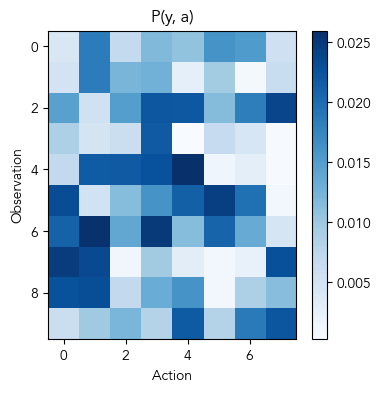

In [4]:
Y = 10
A = 8

np.random.seed(122)
pya = np.random.rand(Y, A)
pya /= pya.sum()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(pya, cmap='Blues', aspect='auto')
plt.colorbar(im)
ax.set_xlabel('Action')
ax.set_ylabel('Observation')
ax.set_title('P(y, a)')
plt.show()

In [5]:
M = 6

np.random.seed(0)
Theta = np.random.randn(Y, M, M, A)
TMat = fun.softmax(Theta, axis = (2, 3))

In [6]:
import numba as nb

@nb.njit
def optimize_rho(TMat, pya, rhok, maxiter, th = 1e-6):

    Y, M, _, A = TMat.shape

    rhok_all = np.zeros((maxiter, M))

    wVec = np.zeros((Y, A, M))
    for y in range(Y):
        for a in range(A):
            for m in range(M):
                wVec[y, a, m] = np.sum(TMat[y, m, :, a])

    for i in range(maxiter):
        wsumexp_test_k = np.zeros((Y, A))
        
        for y in range(Y):
            for a in range(A):
                wsumexp_test_k[y, a] = np.sum(wVec[y, a] * rhok)
        
        grad = wVec * rhok / wsumexp_test_k[..., None]

        rhok_new = np.zeros(M)

        for y in range(Y):
            for a in range(A):
                rhok_new += pya[y, a] * grad[y, a]
        
        if np.linalg.norm(rhok_new - rhok) < th:
            break

        rhok_new /= np.sum(rhok_new)

        rhok_all[i] = rhok_new
        rhok = rhok_new

    return rhok_all

In [7]:
np.random.seed(1)
rho0 = np.random.rand(M)
rho0 /= rho0.sum()

In [8]:
rhok_all = optimize_rho(TMat, pya, rho0, 5000, th = 1e-30)

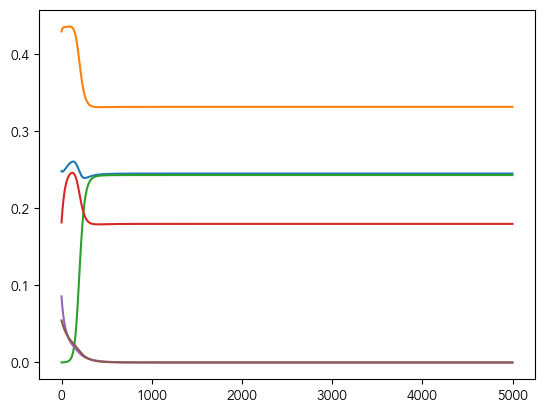

In [9]:
plt.plot(rhok_all)
plt.show()

In [10]:
@nb.njit
def fun_to_min_cc(psi, wVec, psi_k, pya):

    sumexp = np.sum(np.exp(psi))
    wsumexp_k = np.sum(wVec*np.exp(psi_k), axis = 2)

    convexified = np.sum(wVec*np.exp(psi_k)*(psi - psi_k), axis = 2)/wsumexp_k
    convexified += np.log(wsumexp_k)
    convexified = np.sum(pya*convexified)

    return np.log(sumexp) - convexified

NSteps = 1000

rhok_all_bf = np.zeros((NSteps, M))

psik = rho0
wVec = TMat.sum(axis = 2).transpose(0, 2, 1)

for k in range(NSteps):
    x0 = np.zeros(M)

    res = scipy.optimize.minimize(fun_to_min_cc, x0, args = (wVec, psik, pya))

    psik = res.x

    rhok_all_bf[k] = np.exp(psik)/np.sum(np.exp(psik))

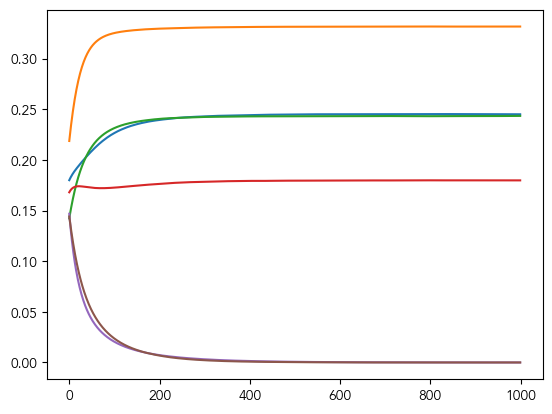

In [11]:
plt.plot(rhok_all_bf)
plt.show()

In [12]:
def fun_arg_rho_tilde(rhoVec, wVec):
    return wVec/(wVec*rhoVec).sum(axis = -1)[..., None]

def fun_to_min(psi, wVec, pya):
    rhoVec = np.exp(psi)
    rhoVec /= rhoVec.sum()

    arg_rho_tilde = fun_arg_rho_tilde(rhoVec, wVec)
    
    return np.sum(pya[..., None]*arg_rho_tilde*rhoVec[None, ...], axis = (0,1)) - rhoVec

def fun_to_min_rho(rhoVec, wVec, pya):
    arg_rho_tilde = fun_arg_rho_tilde(rhoVec, wVec)
    
    return np.sum(pya[..., None]*arg_rho_tilde*rhoVec[None, ...], axis = (0,1)) - rhoVec


def fun_MSE(psi, wVec, pya):
    MSE = fun_to_min(psi, wVec, pya)**2
    return np.sum(np.sqrt(MSE))

def fun_jac_rho(rhoVec):
    M = len(rhoVec)
    jac = np.zeros((M, M))
    for mu in range(M):
        for nu in range(M):
            if mu == nu:
                jac[mu, nu] = rhoVec[mu] - rhoVec[mu]*rhoVec[nu]
            else:
                jac[mu, nu] = -rhoVec[mu]*rhoVec[nu]
    
    return jac

def jac_fun(psi, wVec, pya):
    rhoVec = np.exp(psi)
    rhoVec /= rhoVec.sum()

    M = len(rhoVec)

    arg_rho_tilde = fun_arg_rho_tilde(rhoVec, wVec)
    jac_rho = fun_jac_rho(rhoVec)

    jac = np.zeros((M, M))

    for mu in range(M):
        for nu in range(M):
            temp = arg_rho_tilde[:, :, mu]*(jac_rho[mu, nu] + rhoVec[mu]*rhoVec[nu])
            temp -= arg_rho_tilde[:, :, mu]*arg_rho_tilde[:, :, nu]*rhoVec[mu]*rhoVec[nu]
            
            temp = np.sum(pya*temp)

            jac[mu, nu] = temp - jac_rho[mu, nu]
    return jac

def jac_MSE(psi, wVec, pya):
    M = len(psi)
    jac = jac_fun(psi, wVec, pya)
    f = fun_to_min(psi, wVec, pya)
    fsqrt = np.divide(f, np.sqrt(f**2), out=np.zeros_like(f), where=f!=0)
    
    j = np.zeros(M)

    for nu in range(M):
        for mu in range(M):
            j[nu] += fsqrt[mu]*jac[mu, nu]
    return j


wVec = TMat.sum(axis = 2).transpose(0, 2, 1)

methods_list = ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B',
                'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'trust-ncg', 'trust-krylov']
hess = '2-point'

psi0 = np.random.rand(M)

rho_optimized = []

for method in methods_list:
    res = scipy.optimize.minimize(fun_MSE, psi0, args = (wVec, pya),
                                  jac = jac_MSE, method=method,
                                  hess = hess, options = {'maxiter': 10000})

    psi = res.x
    rho_optimized.append(fun.softmax(psi))

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26778/2056642809.py:80: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  res = scipy.optimize.minimize(fun_MSE, psi0, args = (wVec, pya),
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26778/2056642809.py:80: RuntimeWarning: Method Nelder-Mead does not use Hessian information (hess).
  res = scipy.optimize.minimize(fun_MSE, psi0, args = (wVec, pya),
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26778/2056642809.py:80: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = scipy.optimize.minimize(fun_MSE, psi0, args = (wVec, pya),
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26778/2056642809.py:80: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = scipy.optimize.minimize(fun_MSE, psi0, args = (wVec, pya),
/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_26778/2056642809.py:80: RuntimeWarning: Method 

In [13]:
rho_optimized

[array([1.29079201e-05, 4.11710520e-01, 2.74364301e-01, 2.35529705e-01,
        2.51101161e-12, 7.83825664e-02]),
 array([2.00695072e-36, 4.11731014e-01, 2.74381566e-01, 2.35543831e-01,
        1.94692357e-34, 7.83435895e-02]),
 array([0.23788122, 0.34735956, 0.25811018, 0.08723294, 0.02422643,
        0.04518967]),
 array([0.23818189, 0.3228961 , 0.2394694 , 0.17672442, 0.00820449,
        0.01452369]),
 array([3.17272677e-06, 4.28154481e-06, 5.91002166e-06, 9.99986633e-01,
        6.91498967e-10, 2.03465036e-09]),
 array([0.23055137, 0.31994486, 0.23641351, 0.17495392, 0.01411703,
        0.02401931]),
 array([0.21253961, 0.33131254, 0.22952587, 0.13323902, 0.04062842,
        0.05275455]),
 array([0.22204496, 0.32847399, 0.23816857, 0.14768164, 0.03385299,
        0.02977785]),
 array([0.24012825, 0.32462454, 0.24143062, 0.17759159, 0.00579819,
        0.01042681]),
 array([0.26834304, 0.5307643 , 0.05373523, 0.03472971, 0.04263238,
        0.06979534]),
 array([0.20992159, 0.350182

In [16]:
rhok_all[-1], rhok_all_bf[-1]

(array([2.45168503e-01, 3.31715117e-01, 2.43250131e-01, 1.79866249e-01,
        6.54362224e-18, 1.65848836e-24]),
 array([2.45056130e-01, 3.31680836e-01, 2.43457299e-01, 1.79790075e-01,
        7.82968126e-06, 7.82964442e-06]))

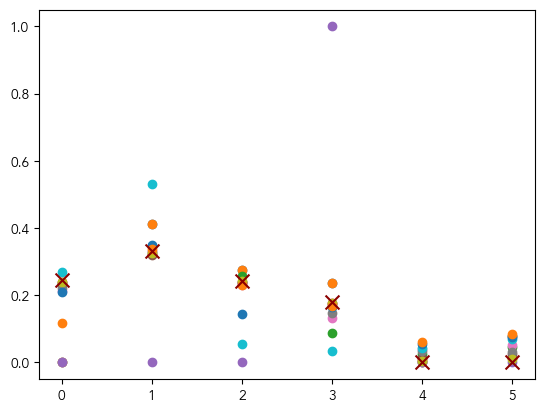

In [14]:
for rho in rho_optimized:
    plt.scatter(np.arange(M), rho)
plt.scatter(np.arange(M), rhok_all[-1], c = 'darkred', marker = 'x', s = 100)

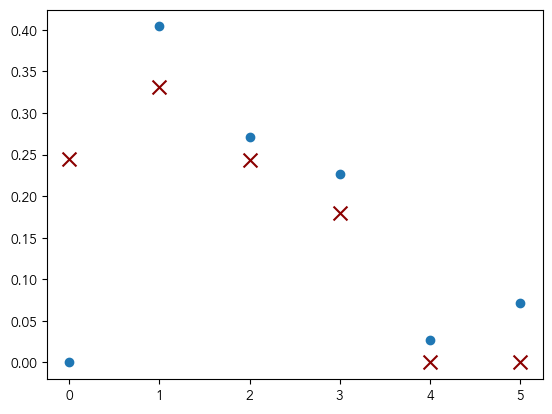

In [106]:
plt.scatter(np.arange(M), rho_optimized[1])
plt.scatter(np.arange(M), rhok_all[-1], c = 'darkred', marker = 'x', s = 100)

In [123]:
np.sum(rho_optimized[1])

1.0

In [124]:
abs(fun_to_min_rho(rho_optimized[1], wVec, pya))

array([2.60510898e-31, 8.88178420e-15, 2.81996648e-14, 1.97064587e-14,
       3.71230824e-16, 0.00000000e+00])

In [125]:
abs(fun_to_min_rho(rhok_all[-1], wVec, pya))

array([8.32667268e-17, 5.55111512e-17, 5.55111512e-17, 2.77555756e-17,
       4.72385876e-20, 1.73347449e-26])

In [126]:
rhotest = np.zeros(M)
rhotest[0] = 1

abs(fun_to_min_rho(rhotest, wVec, pya))

array([0., 0., 0., 0., 0., 0.])

In [127]:
likelihood_values_opt = []

for rho in rho_optimized:
    likelihood_values_opt.append(-np.sum(pya*np.log(np.sum((wVec*rho), axis = -1))))

likelihood_value_cc = -np.sum(pya*np.log(np.sum((wVec*rhok_all[-1]), axis = -1)))

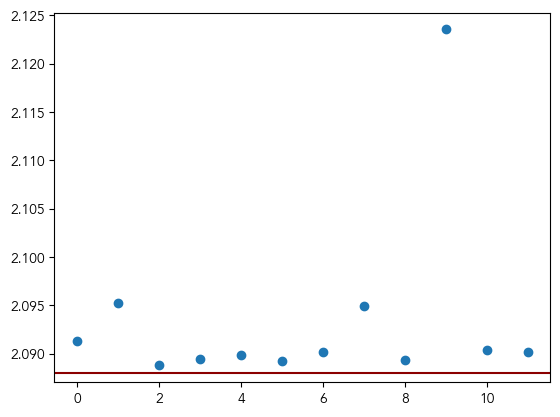

In [128]:
plt.plot(likelihood_values_opt, 'o')
plt.axhline(likelihood_value_cc, c = 'darkred')

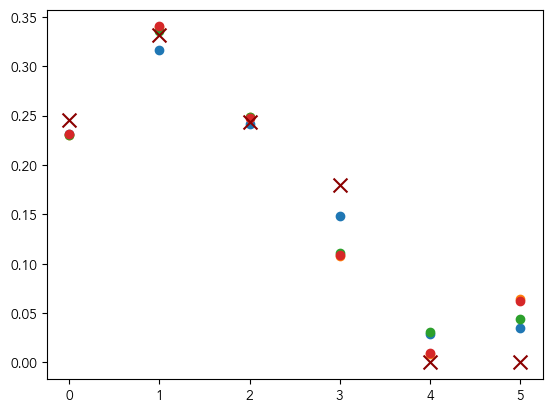

In [129]:
plt.scatter(np.arange(M), rho_optimized[2])
plt.scatter(np.arange(M), rho_optimized[3])
plt.scatter(np.arange(M), rho_optimized[5])
plt.scatter(np.arange(M), rho_optimized[8])
plt.scatter(np.arange(M), rhok_all[-1], c = 'darkred', marker = 'x', s = 100)

In [138]:
rhok_test_pow = optimize_rho(TMat, pya, rho_optimized[1], 5000, th = 1e-30)

In [150]:
rho_perturbed = rho_optimized[1] + 1e-9*np.random.rand(M)
rho_perturbed /= rho_perturbed.sum()

rhok_test_pert = optimize_rho(TMat, pya, rho_perturbed, 5000, th = 1e-30)

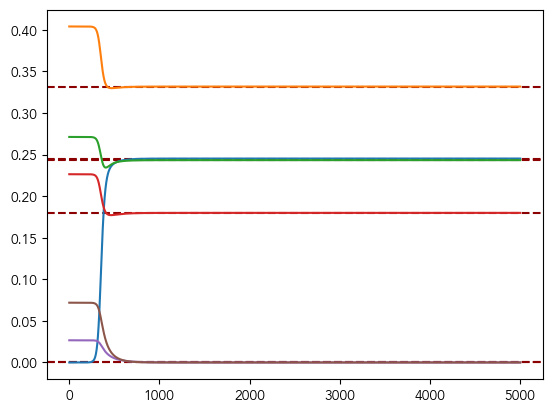

In [151]:
for m in range(M):
    plt.axhline(rhok_all[-1][m], c = 'darkred', linestyle = '--')
plt.plot(rhok_test_pert)
plt.show()

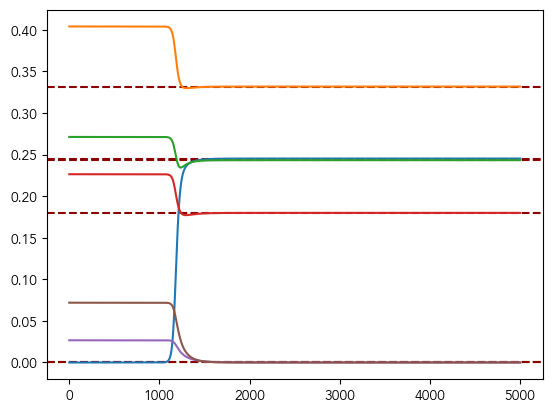

In [139]:
for m in range(M):
    plt.axhline(rhok_all[-1][m], c = 'darkred', linestyle = '--')
plt.plot(rhok_test_pow)
plt.show()